In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

--2023-06-08 04:38:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.5MB/s    in 8.5s    

2023-06-08 04:38:18 (19.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
zip=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip.extractall()
zip.close()

In [5]:
for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 10 directori

In [6]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE=32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [17]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [29]:
resnet_url='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url='https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

In [12]:
def create_model(model_url,num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = 'feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  model=tf.keras.Sequential()
  model.add(feature_extraction_layer)
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer'))
  return model

In [13]:
resnet_model=create_model(resnet_url, train_data.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                     metrics=['accuracy'])


In [18]:
resnet_model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='resnetv250')])

Saving TensorBoard log files to: tensorflow_hub/resnetv250/20230608-051345
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.5365 - accuracy: 0.5213 - val_loss: 0.7542 - val_accuracy: 0.7448
Epoch 2/5
24/24 [==============================] - 19s 813ms/step - loss: 0.4951 - accuracy: 0.8267 - val_loss: 0.6583 - val_accuracy: 0.7764
Epoch 3/5
24/24 [==============================] - 18s 789ms/step - loss: 0.2770 - accuracy: 0.9253 - val_loss: 0.6573 - val_accuracy: 0.7816
Epoch 4/5
24/24 [==============================] - 19s 812ms/step - loss: 0.1825 - accuracy: 0.9640 - val_loss: 0.6520 - val_accuracy: 0.7844
Epoch 5/5
24/24 [==============================] - 18s 785ms/step - loss: 0.1229 - accuracy: 0.9933 - val_loss: 0.6444 - val_accuracy: 0.7888


In [23]:
def plot_loss_curves(history):
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']
  epochs=range(len(history.history['loss']))
  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs,accuracy,label='trainiing_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


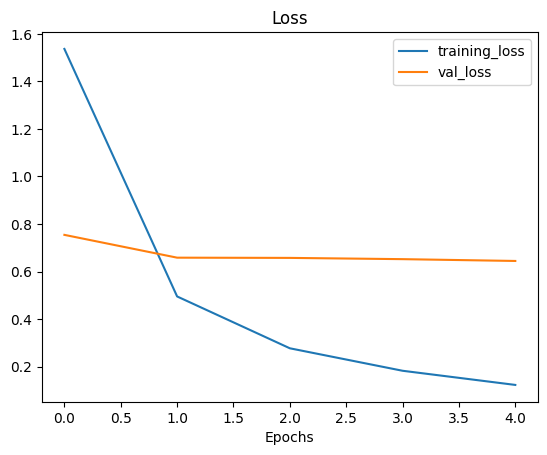

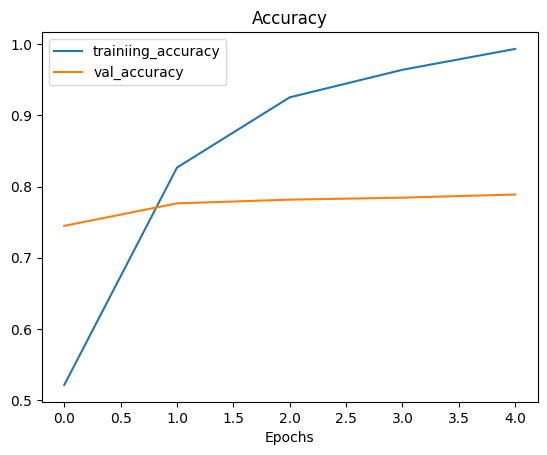

In [24]:
plot_loss_curves(resnet_model.history)

In [30]:
efficientnet_model=create_model(efficientnet_url, train_data.num_classes)

In [32]:
efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                     metrics=['accuracy'])

In [33]:
efficientnet_model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=test_data,validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',experiment_name='efficientnetv2b0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetv2b0/20230608-053644
Epoch 1/5
24/24 [==============================] - 32s 992ms/step - loss: 1.5193 - accuracy: 0.5240 - val_loss: 0.9534 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 20s 881ms/step - loss: 0.7607 - accuracy: 0.7747 - val_loss: 0.7314 - val_accuracy: 0.7652
Epoch 3/5
24/24 [==============================] - 19s 827ms/step - loss: 0.5476 - accuracy: 0.8547 - val_loss: 0.7076 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 21s 881ms/step - loss: 0.4442 - accuracy: 0.9053 - val_loss: 0.6568 - val_accuracy: 0.7856
Epoch 5/5
24/24 [==============================] - 20s 841ms/step - loss: 0.3560 - accuracy: 0.9347 - val_loss: 0.6352 - val_accuracy: 0.7884


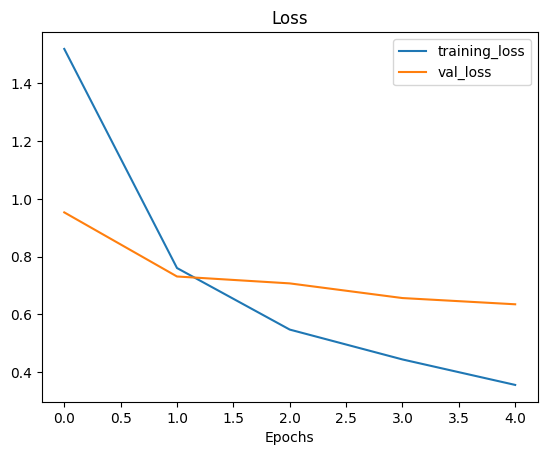

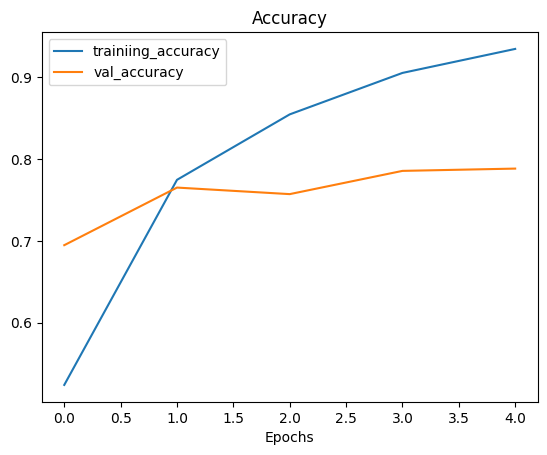

In [34]:
plot_loss_curves(efficientnet_model.history)

In [35]:
!tensorboard dev upload --logdir ./tensorflow_hub/ --name 'EfficientNetB0 vs ResnetV250' --description 'Comparing two different transfer learning architectures' --one_shot

2023-06-08 06:07:51.400965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   GDG-YBB-PFD



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

In [36]:
!tensorboard dev list

2023-06-08 06:16:38.449255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/Z14mRIWvQ4KJiz1e62pfrw/
	Name                 EfficientNetB0 vs ResnetV250
	Description          Comparing two different transfer learning architectures
	Id                   Z14mRIWvQ4KJiz1e62pfrw
	Created              2023-06-08 06:12:18 (4 minutes ago)
	Updated              2023-06-08 06:12:22 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  4516559
Total: 1 experiment(s)
